# Potential Plot
> - Extension following Oleg's discussion on 2020-06-28

Minimization of the following:

$$
\bar{u}_\text{pot} = \frac{U}{E_J} = -\big[ \alpha\cos(\varphi_{02}) + \cos(\varphi_{03}) + \cos(\varphi_{01}) + \\
+ \cos(\varphi_{02} - \varphi_{01} - L) + \cos(\varphi_{02} - \varphi_{03} + R)\big]
$$

In [53]:
import math
import itertools
from collections import defaultdict

pi = math.pi

import numpy as np
from numba import cuda
from numba.cuda.cudadrv.devicearray import DeviceNDArray
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
plt.style.use('my_official')

from functions.potential import potential_function_cuda
from kernels.potential_evaluator import PotentialEvaluator
from kernels.potential_minimum_searcher import PotentialMinimumSearcher
from utils.array_stacker import ArrayStacker

# Parameters of the simulation

In [69]:
NUMBER_OF_PHI_POINTS = 100
NUMBER_OF_FIELD_POINTS = 1000
NUMBER_OF_FIELD_POINTS_PER_RUN = 50
NUMBER_OF_FIELD_RUNS = (
    NUMBER_OF_FIELD_POINTS - 1
) // NUMBER_OF_FIELD_POINTS_PER_RUN + 1
ALPHA = 1
LOWER = -0.5
UPPER = 1.5

lr_array = np.linspace(LOWER * 2 * pi, UPPER * 2 * pi, NUMBER_OF_FIELD_POINTS)
phixx_array = np.linspace(-pi, pi, NUMBER_OF_PHI_POINTS)

# Create kernels to cuda

In [70]:
BLOCKS_PER_GRID = (NUMBER_OF_FIELD_POINTS_PER_RUN, NUMBER_OF_FIELD_POINTS_PER_RUN)

potential_evaluator = PotentialEvaluator(NUMBER_OF_PHI_POINTS, potential_function_cuda)
THREADS_PER_BLOCK_potential_evaluation = potential_evaluator.allocate_max_threads(8)

potential_minimum_searcher = PotentialMinimumSearcher(NUMBER_OF_PHI_POINTS)
THREADS_PER_BLOCK_potential_search = potential_minimum_searcher.allocate_max_threads()

🐳 Allocating           THREADS_PER_BLOCK = (8, 8, 8)
🐳 Allocating           THREADS_PER_BLOCK = (32, 32)


# Execution
- Allocate arrays on GPU
- As we split the field up into quadrants, create a quadrant array that will stitch fields together
- Collect up results
- Plot

In [71]:
# Allocate memeoty on GPU
DEVICE_lr_array = cuda.to_device(lr_array)
DEVICE_phixx_array = cuda.to_device(phixx_array)
DEVICE_potential_array = cuda.device_array(
    shape=(
        NUMBER_OF_FIELD_POINTS_PER_RUN,
        NUMBER_OF_FIELD_POINTS_PER_RUN,
        NUMBER_OF_PHI_POINTS,
        NUMBER_OF_PHI_POINTS,
        NUMBER_OF_PHI_POINTS,
    ),
    dtype=np.float64,
)
DEVICE_grid_search_result_array = cuda.device_array(
    shape=(NUMBER_OF_FIELD_POINTS_PER_RUN, NUMBER_OF_FIELD_POINTS_PER_RUN, 4),
    dtype=np.float32,
)

# Go through teach of the field section and evaluate ##########################
quadrants = defaultdict(lambda: [[None] * NUMBER_OF_FIELD_RUNS for i in range(0, NUMBER_OF_FIELD_RUNS)])
for (L_RUN, R_RUN) in itertools.product(
    range(0, NUMBER_OF_FIELD_RUNS), range(0, NUMBER_OF_FIELD_RUNS)
):
    L_OFFSET = int(L_RUN * NUMBER_OF_FIELD_POINTS_PER_RUN)
    R_OFFSET = int(R_RUN * NUMBER_OF_FIELD_POINTS_PER_RUN)
    print(
        f"🦑 Running (L={L_RUN}/{NUMBER_OF_FIELD_RUNS - 1}, L_offset={L_OFFSET}), (R={R_RUN}/{NUMBER_OF_FIELD_RUNS - 1}, R_offset={R_OFFSET})"
    )
    potential_evaluator.kernel[BLOCKS_PER_GRID, THREADS_PER_BLOCK_potential_evaluation](
        DEVICE_phixx_array,
        DEVICE_lr_array,
        L_OFFSET,
        R_OFFSET,
        ALPHA,
        DEVICE_potential_array,
    )
    
    potential_minimum_searcher.kernel[
        BLOCKS_PER_GRID, THREADS_PER_BLOCK_potential_search
    ](DEVICE_potential_array, DEVICE_grid_search_result_array)
        
    grid_search_result_array = DEVICE_grid_search_result_array.copy_to_host()
    
    quadrants["potential"][L_RUN][R_RUN] = grid_search_result_array[:,:,0]
    quadrants["phi01"][L_RUN][R_RUN] = phixx_array[grid_search_result_array[:,:,1].astype(int)]
    quadrants["phi02"][L_RUN][R_RUN] = phixx_array[grid_search_result_array[:,:,2].astype(int)]
    quadrants["phi03"][L_RUN][R_RUN] = phixx_array[grid_search_result_array[:,:,3].astype(int)]

🦑 Running (L=0/19, L_offset=0), (R=0/19, R_offset=0)
🦑 Running (L=0/19, L_offset=0), (R=1/19, R_offset=50)
🦑 Running (L=0/19, L_offset=0), (R=2/19, R_offset=100)
🦑 Running (L=0/19, L_offset=0), (R=3/19, R_offset=150)
🦑 Running (L=0/19, L_offset=0), (R=4/19, R_offset=200)
🦑 Running (L=0/19, L_offset=0), (R=5/19, R_offset=250)
🦑 Running (L=0/19, L_offset=0), (R=6/19, R_offset=300)
🦑 Running (L=0/19, L_offset=0), (R=7/19, R_offset=350)
🦑 Running (L=0/19, L_offset=0), (R=8/19, R_offset=400)
🦑 Running (L=0/19, L_offset=0), (R=9/19, R_offset=450)
🦑 Running (L=0/19, L_offset=0), (R=10/19, R_offset=500)
🦑 Running (L=0/19, L_offset=0), (R=11/19, R_offset=550)
🦑 Running (L=0/19, L_offset=0), (R=12/19, R_offset=600)
🦑 Running (L=0/19, L_offset=0), (R=13/19, R_offset=650)
🦑 Running (L=0/19, L_offset=0), (R=14/19, R_offset=700)
🦑 Running (L=0/19, L_offset=0), (R=15/19, R_offset=750)
🦑 Running (L=0/19, L_offset=0), (R=16/19, R_offset=800)
🦑 Running (L=0/19, L_offset=0), (R=17/19, R_offset=850)
🦑 Run

🦑 Running (L=7/19, L_offset=350), (R=2/19, R_offset=100)
🦑 Running (L=7/19, L_offset=350), (R=3/19, R_offset=150)
🦑 Running (L=7/19, L_offset=350), (R=4/19, R_offset=200)
🦑 Running (L=7/19, L_offset=350), (R=5/19, R_offset=250)
🦑 Running (L=7/19, L_offset=350), (R=6/19, R_offset=300)
🦑 Running (L=7/19, L_offset=350), (R=7/19, R_offset=350)
🦑 Running (L=7/19, L_offset=350), (R=8/19, R_offset=400)
🦑 Running (L=7/19, L_offset=350), (R=9/19, R_offset=450)
🦑 Running (L=7/19, L_offset=350), (R=10/19, R_offset=500)
🦑 Running (L=7/19, L_offset=350), (R=11/19, R_offset=550)
🦑 Running (L=7/19, L_offset=350), (R=12/19, R_offset=600)
🦑 Running (L=7/19, L_offset=350), (R=13/19, R_offset=650)
🦑 Running (L=7/19, L_offset=350), (R=14/19, R_offset=700)
🦑 Running (L=7/19, L_offset=350), (R=15/19, R_offset=750)
🦑 Running (L=7/19, L_offset=350), (R=16/19, R_offset=800)
🦑 Running (L=7/19, L_offset=350), (R=17/19, R_offset=850)
🦑 Running (L=7/19, L_offset=350), (R=18/19, R_offset=900)
🦑 Running (L=7/19, L_o

🦑 Running (L=14/19, L_offset=700), (R=1/19, R_offset=50)
🦑 Running (L=14/19, L_offset=700), (R=2/19, R_offset=100)
🦑 Running (L=14/19, L_offset=700), (R=3/19, R_offset=150)
🦑 Running (L=14/19, L_offset=700), (R=4/19, R_offset=200)
🦑 Running (L=14/19, L_offset=700), (R=5/19, R_offset=250)
🦑 Running (L=14/19, L_offset=700), (R=6/19, R_offset=300)
🦑 Running (L=14/19, L_offset=700), (R=7/19, R_offset=350)
🦑 Running (L=14/19, L_offset=700), (R=8/19, R_offset=400)
🦑 Running (L=14/19, L_offset=700), (R=9/19, R_offset=450)
🦑 Running (L=14/19, L_offset=700), (R=10/19, R_offset=500)
🦑 Running (L=14/19, L_offset=700), (R=11/19, R_offset=550)
🦑 Running (L=14/19, L_offset=700), (R=12/19, R_offset=600)
🦑 Running (L=14/19, L_offset=700), (R=13/19, R_offset=650)
🦑 Running (L=14/19, L_offset=700), (R=14/19, R_offset=700)
🦑 Running (L=14/19, L_offset=700), (R=15/19, R_offset=750)
🦑 Running (L=14/19, L_offset=700), (R=16/19, R_offset=800)
🦑 Running (L=14/19, L_offset=700), (R=17/19, R_offset=850)
🦑 Runni

In [72]:
result = {key: ArrayStacker.stack_into_square(value)
                 for key, value in quadrants.items()}

for key in ["phi01", "phi02", "phi03"]:
    result[key] = result[key] / (2 * pi)

<IPython.core.display.Javascript object>


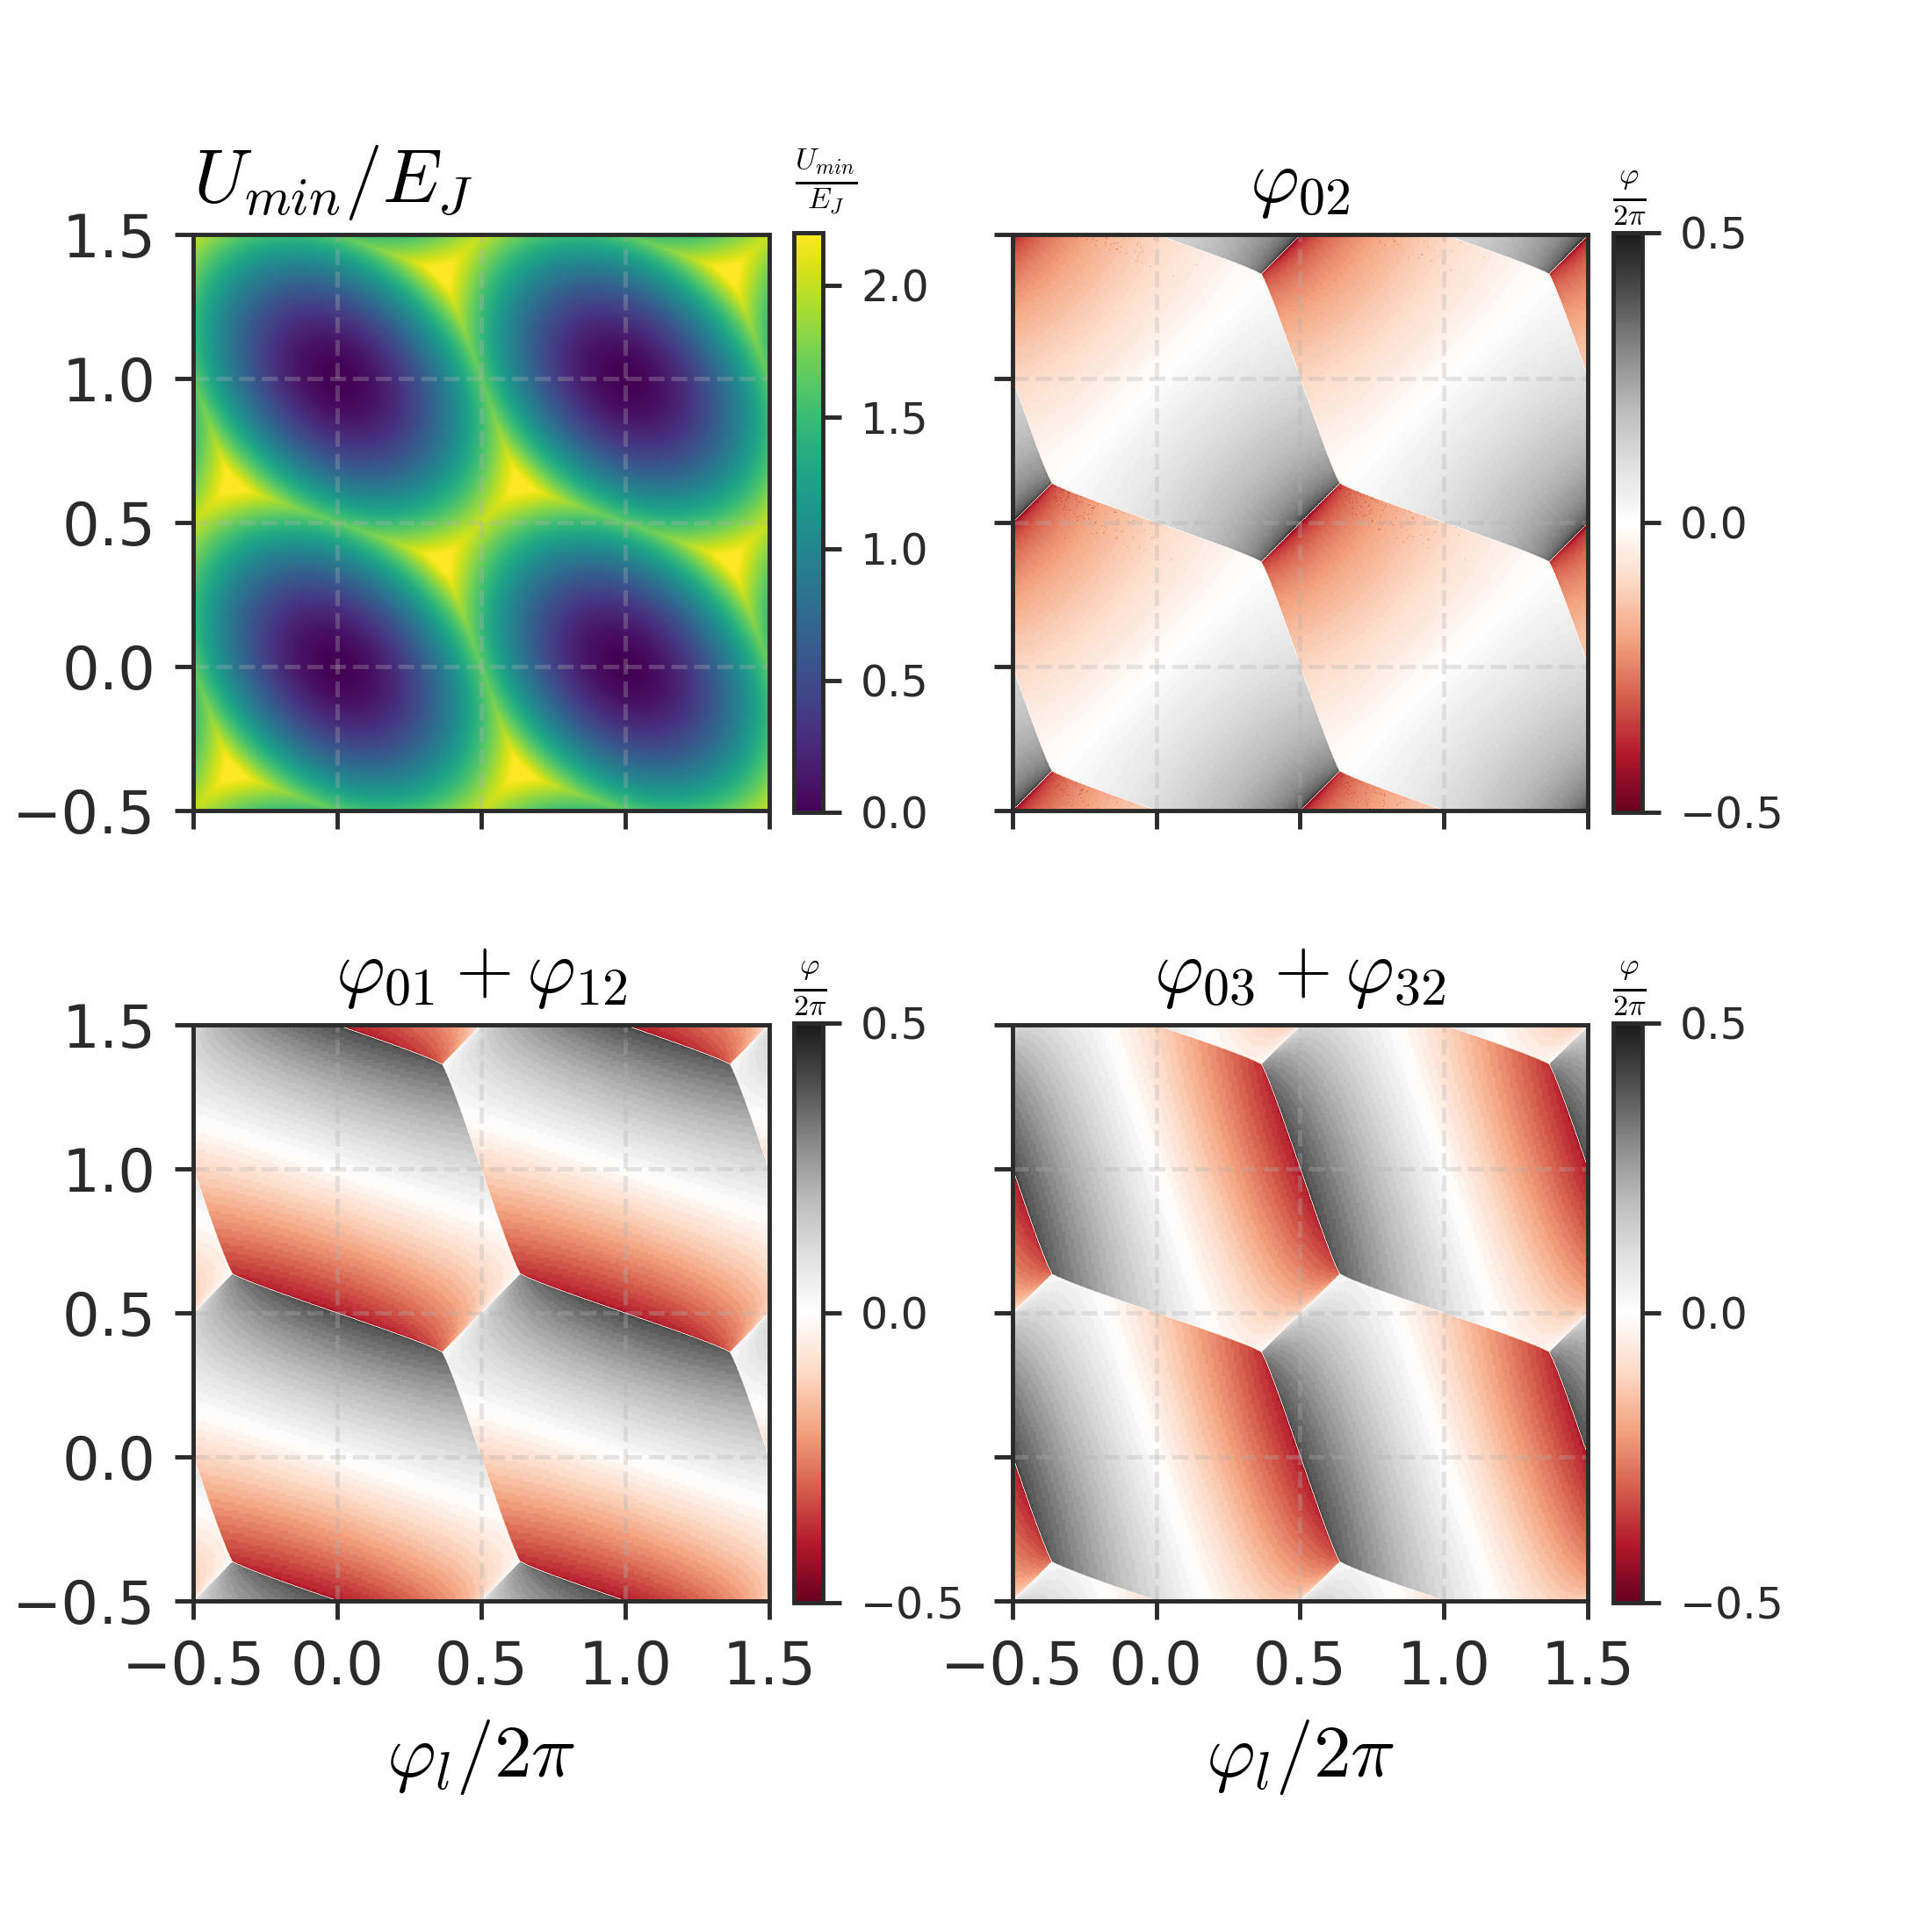

Text(0.5, 0, '$\\varphi_l/2\\pi$')

In [213]:
%matplotlib notebook
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(5, 5))
plt.subplots_adjust(left=0.1, bottom=None, right=0.85, top=None, wspace=None, hspace=None)
cb = defaultdict(lambda: defaultdict(int))
im = defaultdict(lambda: defaultdict(int))

im[0][0] = ax[0][0].imshow(result["potential"],
               extent = [LOWER, UPPER, LOWER, UPPER],
               origin='lower',
               interpolation='bessel',
                vmin=0, vmax=2.2)
ax[0][0].set_title(r"$U_{min}/E_J$", fontsize=14, loc="left")

im[0][1] = ax[0][1].imshow(result["phi02"],
               extent = [LOWER, UPPER, LOWER, UPPER],
               origin='lower',
               cmap='RdGy', 
               interpolation='bessel',
               vmin=-0.5, vmax=0.5)
ax[0][1].set_title(r"$\varphi_{02}$", fontsize=14)

im[1][0] = ax[1][0].imshow(result["phi01"] + result["phi01"],
               extent = [LOWER, UPPER, LOWER, UPPER],
               origin='lower',
               cmap='RdGy',
               interpolation='bessel',
               vmin=-0.5, vmax=0.5)
ax[1][0].set_title(r"$\varphi_{01} + \varphi_{12}$", fontsize=14)

im[1][1] = ax[1][1].imshow(result["phi03"] + result["phi03"],
               extent = [LOWER, UPPER, LOWER, UPPER],
               origin='lower',
               cmap='RdGy',
               interpolation='bessel',
               vmin=-0.5, vmax=0.5)
ax[1][1].set_title(r"$\varphi_{03} + \varphi_{32}$", fontsize=14)

# Colorbars
for (i, j) in list(itertools.product([0,1], [0,1])):
    if i == 0 and j == 0:
        cb[i][j] = fig.colorbar(im[i][j], ax=ax[i][j], fraction=0.046, pad=0.04)
        cb[i][j].ax.set_ylabel(r"$\frac{U_{min}}{E_J}$", fontsize=8, rotation=0, ha="left", labelpad=-25, y=1.15)
        cb[i][j].set_ticks([0, 0.5, 1, 1.5, 2])
    else:
        cb[i][j] = fig.colorbar(im[i][j], ax=ax[i][j], fraction=0.046, pad=0.04)
        cb[i][j].ax.set_ylabel(r"$\frac{\varphi}{2\pi}$", fontsize=8, rotation=0, ha="left", labelpad=-32, y=1.11)
        cb[i][j].set_ticks([-0.5, 0, 0.5])
    cb[i][j].ax.tick_params(labelsize=8)

# X ticks
ax[0][0].set_xticks([-0.5, 0, 0.5, 1, 1.5])
# Axes Labels
ax[0][0].set_ylabel(r"$\varphi_r/2\pi$", fontsize=14)
ax[1][0].set_xlabel(r"$\varphi_l/2\pi$", fontsize=14)
ax[1][0].set_ylabel(r"$\varphi_r/2\pi$", fontsize=14)
ax[1][1].set_xlabel(r"$\varphi_l/2\pi$", fontsize=14)

In [202]:
from common import plotter
plotter.save_onto_white_background(ax, "./output/potential_minimum_diamonds", "pdf")

<IPython.core.display.Javascript object>


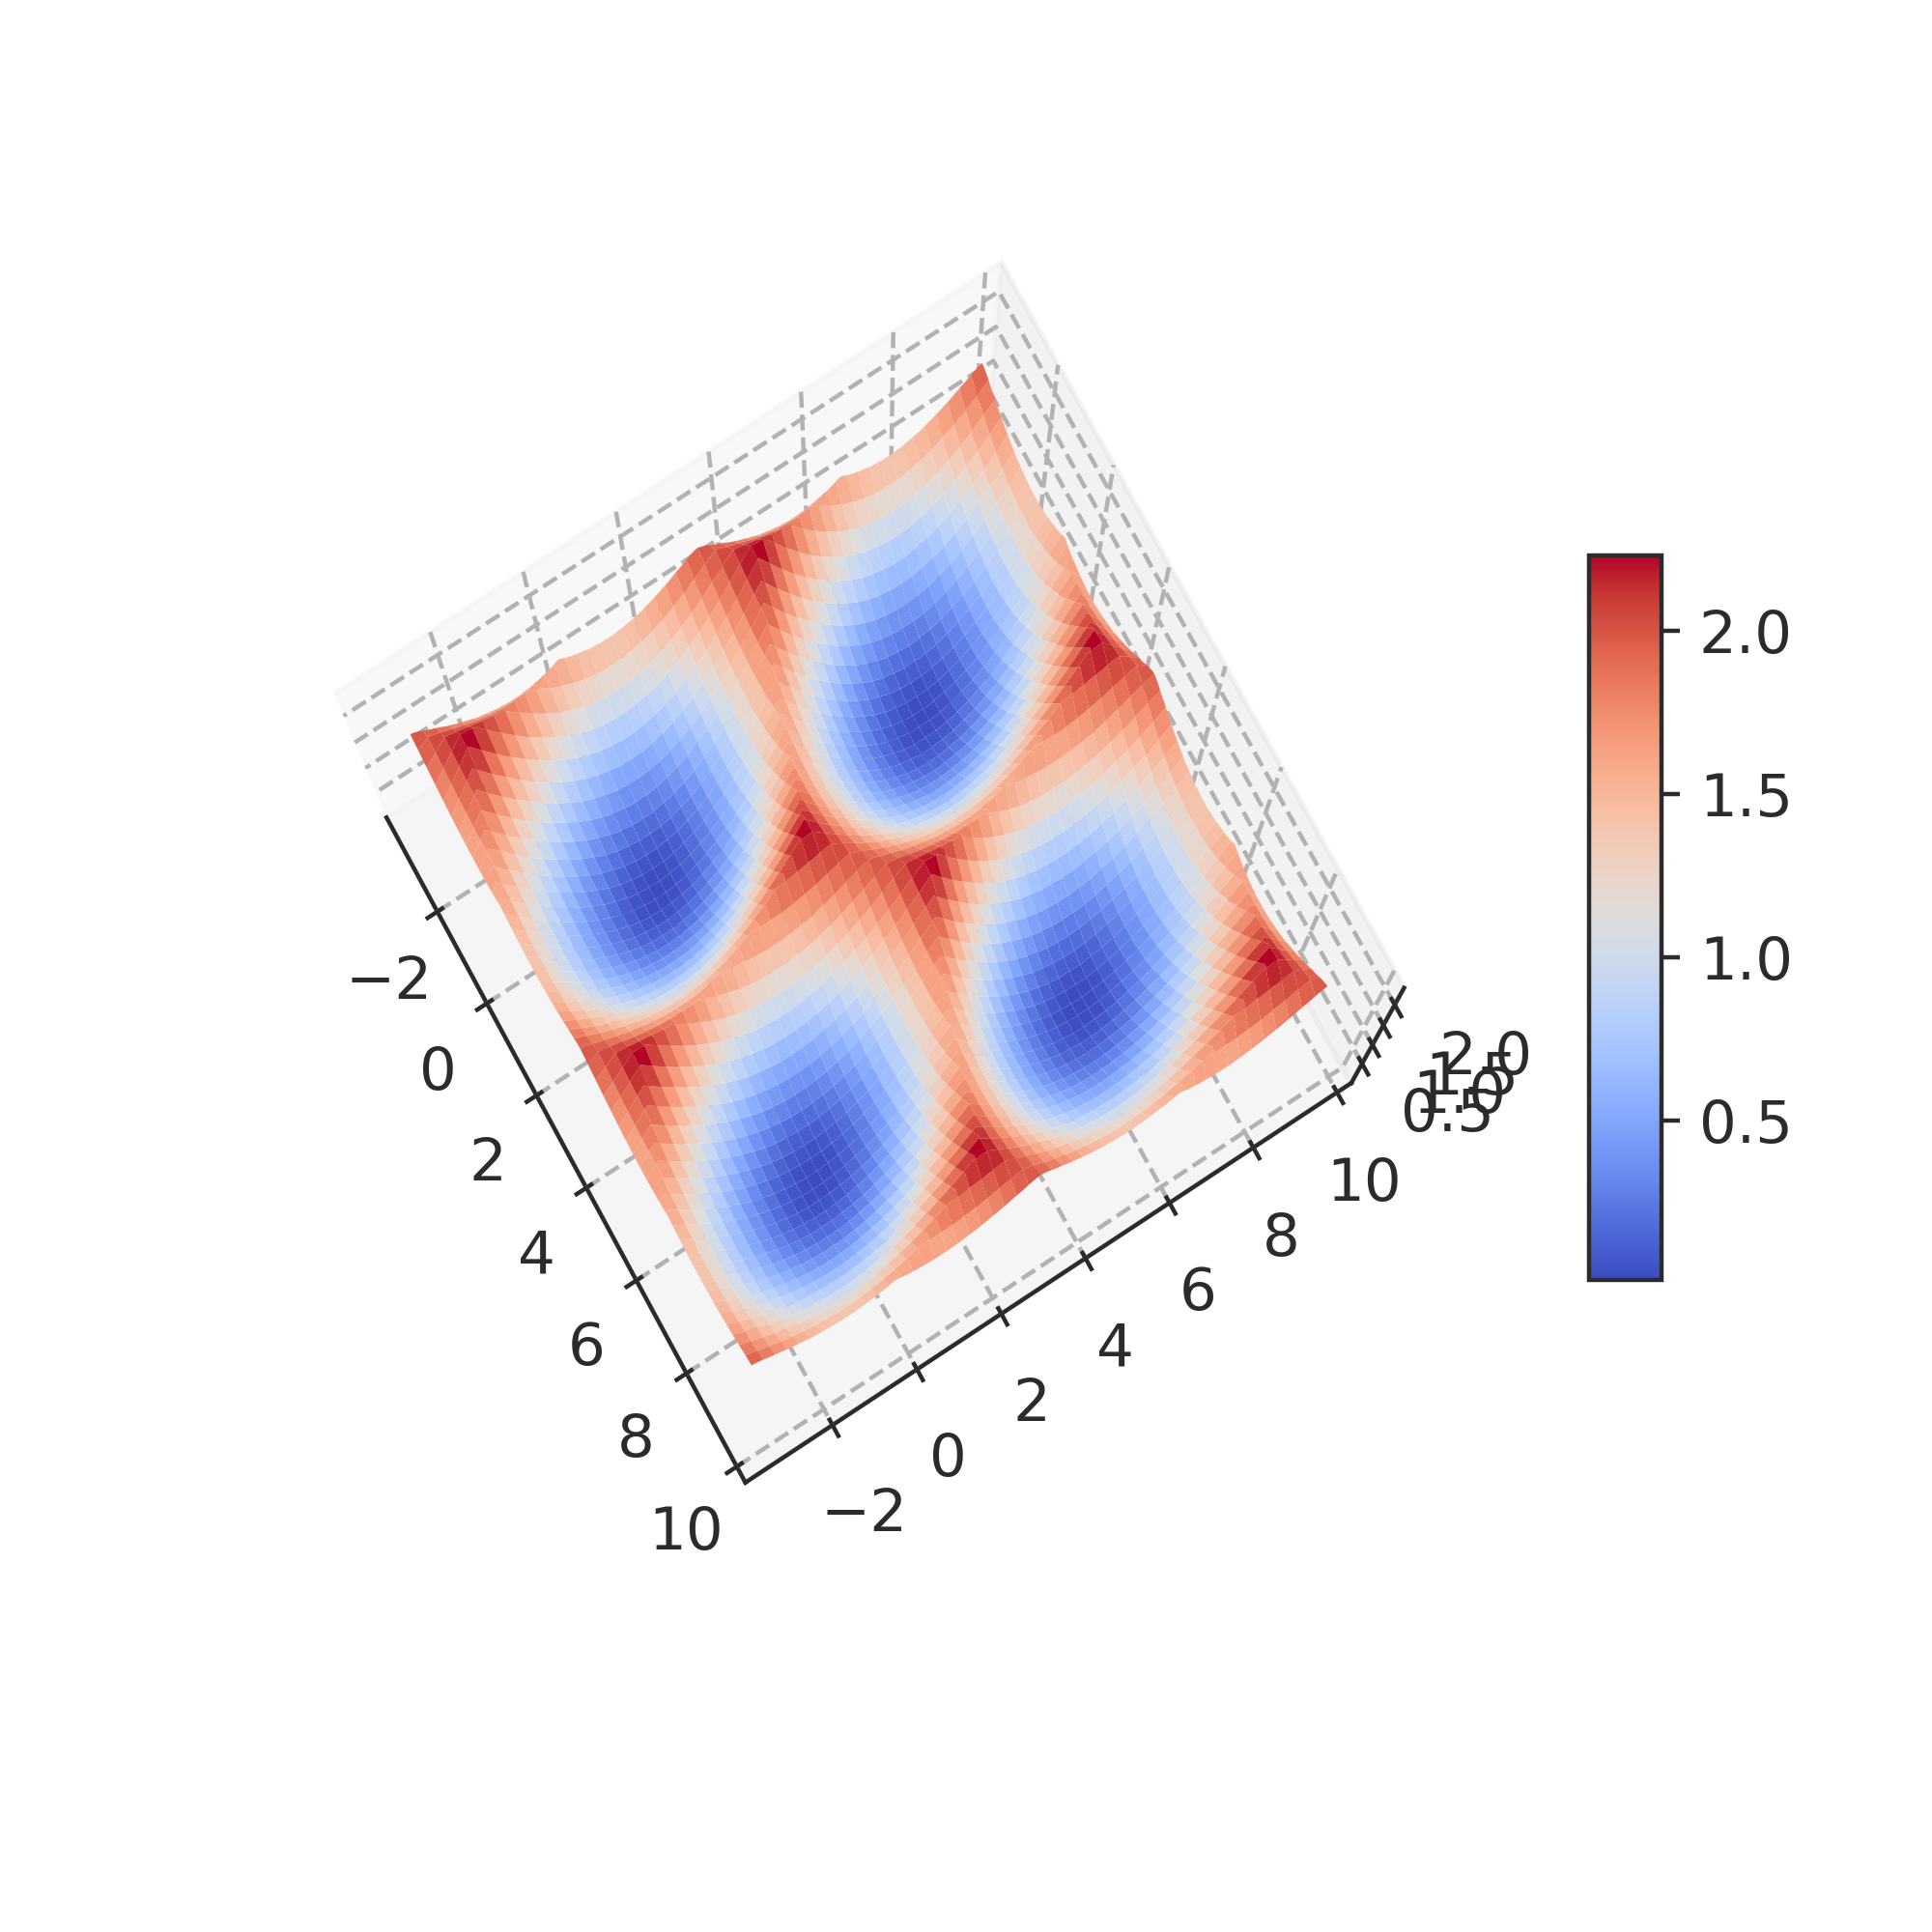

In [67]:
%matplotlib notebook

fig = plt.figure(figsize=(5,5))
ax = fig.gca(projection='3d')

grid_x, grid_y = np.meshgrid(lr_array, lr_array)
surf = ax.plot_surface(grid_x, grid_y, 
                       result["potential"], 
                       #quadrants["potential"][0][0],
                       cmap=cm.coolwarm,
                       linewidth=0, antialiased=True)
fig.colorbar(surf, shrink=0.5, aspect=10)

# Take slices of the potential
- Along $\varphi_l == \varphi_r$
- Along $\frac{\varphi_l + \varphi_r}{2} = \pi \equiv \varphi_+$ 
- And also do the approximation:
$$\varphi_{02} \approx \frac{\varphi_l-\varphi_r - 2\pi(L-R)}{2(1+\alpha)}$$
$$\frac{U_\text{min}}{E_J}   \approx \left(\frac{\varphi_{02}   - \varphi_l + 2\pi L}{2}\right)^2 + \left(\frac{\varphi_{02} +  \varphi_r - 2\pi R}{2}\right)^2 + \frac{\alpha}{2}\varphi_{02}^2$$

In [263]:
def phi02_approximation(phi_l: float, phi_r: float, L: int, R: int, alpha: float):
    return (phi_l - phi_r - 2 * pi * (L - R)) / (2 * (1 + alpha))
def potential_approximation(phi02: float, phi_l: float, phi_r: float, L: int, R: int, alpha: float):
    return (phi02 - phi_l + 2 * pi * L) ** 2 / 4 + (phi02 + phi_r - 2 * pi * R) ** 2 / 4 + alpha * phi02 ** 2 / 2

In [292]:
# Along phi+ and approximation
result["potential_phi_plus"] = []
result["potential_phi_approximation"] = []
result["potential_phi_approximation_01"] = []
result["potential_phi_approximation_10"] = []
length_of_lr_array = len(lr_array)
alpha = 1

for phi_l_idx, phi_l in enumerate(lr_array):
    phi_r_idx = length_of_lr_array - phi_l_idx - 1
    phi_r = lr_array[phi_r_idx]
    
    result["potential_phi_plus"].append(
        result["potential"][phi_l_idx][phi_r_idx]
    )
    
    min_potential = None
    for (L, R) in itertools.permutations([-1, 0, 1], r=2):
        phi02 = phi02_approximation(phi_l, phi_r, L, R, alpha)
        potential = potential_approximation(phi02, phi_l, phi_r, L, R, alpha)
        if min_potential is None or potential < min_potential:
            min_potential = potential
        if L == 0 and R == 1:
            result["potential_phi_approximation_01"].append(potential)
        if L == 1 and R == 0:
            result["potential_phi_approximation_10"].append(potential)
            
    result["potential_phi_approximation"].append(min_potential)

<IPython.core.display.Javascript object>


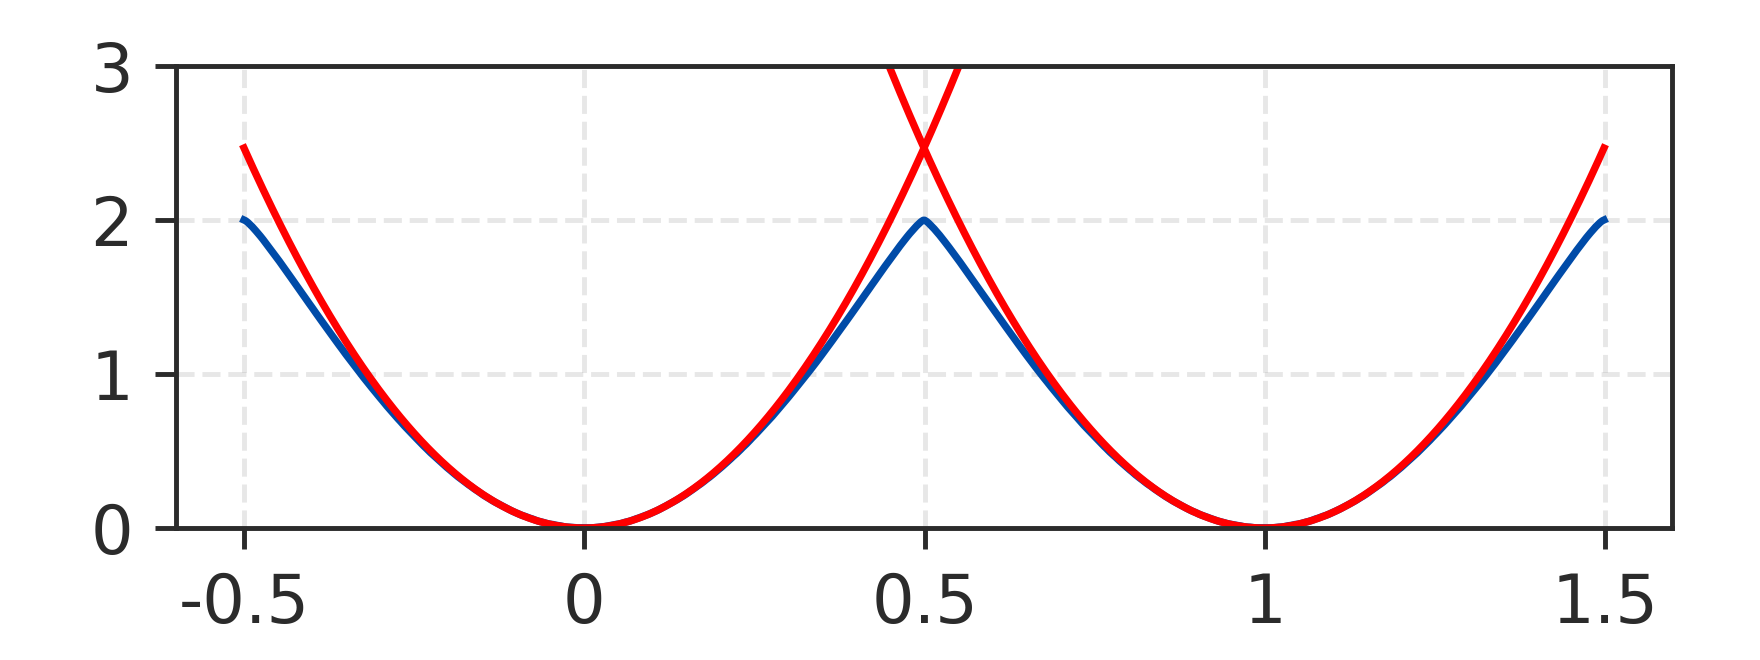

[Text(0, 0, '-0.5'),
 Text(0, 0, '0'),
 Text(0, 0, '0.5'),
 Text(0, 0, '1'),
 Text(0, 0, '1.5')]

In [300]:
%matplotlib notebook
fig, ax = plt.subplots(1, 1, figsize=(4, 1.5))
plt.subplots_adjust(left=None, bottom=0.2, right=None, top=None, wspace=1, hspace=None)

ax.plot(result["potential_phi_plus"])
ax.plot(result["potential_phi_approximation_01"], color='red')
ax.plot(result["potential_phi_approximation_10"], color='red')

# X ticks
ax.set_xticks([0, 250, 500, 750, 1000])
ax.set_ylim([0, 3])
ax.set_xticklabels([-0.5, 0, 0.5, 1, 1.5])